# Domain adaptation analysis

The following notebook shows a study of the classification problem of images belonging to different domains, known as domain adaptation, and the different cases with respect to the problem shown at the following link: [EGO-CH-OBJ-ADAPT](https://iplab.dmi.unict.it/EGO-CH-OBJ-ADAPT/). The proposed problem considers the case of object detection while this notebook aims to study the same problem from the point of view of image classification.

## Initial settings

#### Dependencies

In [ ]:
%pip install --user -qr ./requirements.txt

#### Imports

In [1]:
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics
import torchvision
from torchvision import transforms
import torchvision.models as models

from matplotlib import pyplot as plt

import os
import numpy as np

from scripts.dataset.data_module import CulturalSiteDataModule
from scripts.models.custom_resnet_model import CustomResNetModule

#### Globals

In [8]:
system_accelerator='gpu' #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd
global_resnet_model=models.resnet18(pretrained=False)
global_resnet_model_name='resnet18'
global_log_dir='Official_Training'

c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Models and Tasks examined

Per cominciare si è scelto di analizzare il modello ResNet, di cui il modello più popolare è considerato ResNet50. 
Qui si è scelto di prendere in considerazione l'analisi di Resnet50 e ResNet18 per confrontarne i risultati rispetto al task proposto.

Si è costruito un LightningModule denominato ResNetModule che permette l'utilizzo dei due modelli tramite Pytorch Lightning. Per effettuare analisi con diversi modelli di ResNet, impostare la variabile `global_resnet_model` nella cella sopra.

In [ ]:
class CustomResNetModule(pl.LightningModule):
    def __init__(self, resnet_model, num_classes, lr=1e-3):
        super(CustomResNetModule, self).__init__()
        self.save_hyperparameters(ignore=['resnet_model'])

        self.in_features = resnet_model.fc.in_features

        # pop fully connected layer
        resnet_model._modules.pop(list(resnet_model._modules.keys())[-1])

        # feature extractor from resnet
        self.feature_extractor = nn.Sequential(resnet_model._modules)

        # classifier from resnet
        self.classifier = nn.Sequential(
            nn.Linear(self.in_features, 512),
            nn.Dropout(0.5),
            nn.Linear(512, self.hparams.num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        self.test_prec_rec = torchmetrics.PrecisionRecallCurve(self.hparams.num_classes)
        self.test_f1 = torchmetrics.F1Score(self.hparams.num_classes)

        self.precision = None
        self.recall = None
        self.thresholds = None

    def forward(self, x):
        # features extraction and reshaping to 1-dim array
        features = self.feature_extractor(x).view(x.shape[0], -1)
        return self.classifier(features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):        
        x, y = batch        
        preds = self.forward(x)        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('training/loss', loss.item(), on_epoch=True)
        self.log('training/accuracy', self.train_acc, on_epoch=True)
        
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        output = self.forward(x)
        
        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }
        
    def test_epoch_end(self, outputs):
        predictions = np.concatenate([o['predictions'] for o in outputs])
        labels = np.concatenate([o['labels'] for o in outputs])

        self.test_acc(predictions, labels)   
        self.precision, self.recall, self.thresholds = self.test_prec_rec(predictions, labels)
        self.test_f1(predictions, labels)

## Dataset preanalysis

The cell below setup the dataset. It downloads, unpacks, and extracts patches from the original dataset. It may take a while on the first execution, then it will recognize the datasets and loads them taking a relatively short time.

In [3]:
# REQUIRED the first execution
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


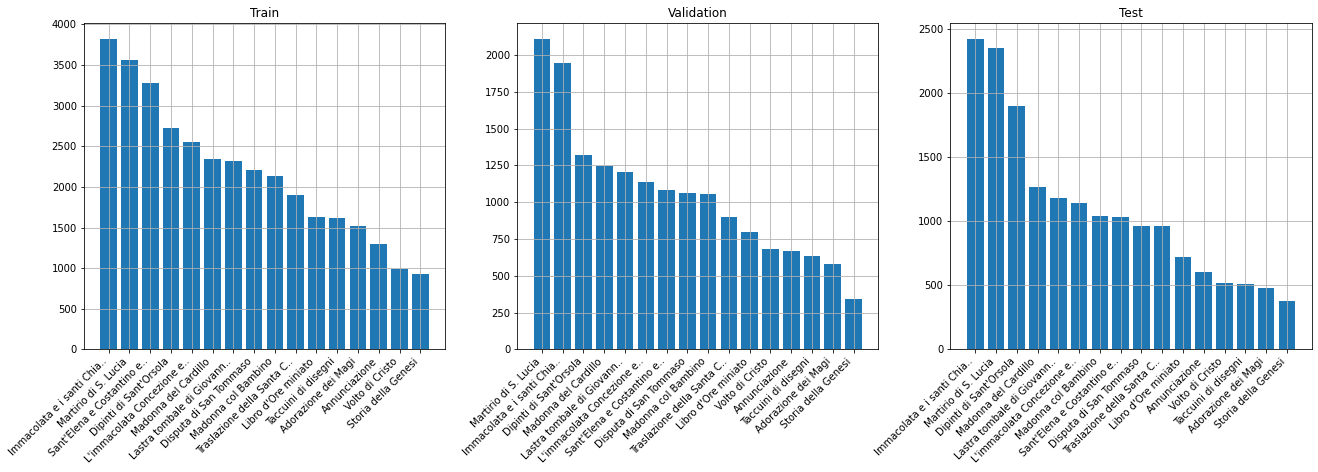

In [9]:
fig, (train_subplot, val_subplot, test_subplot) = plt.subplots(1, 3)
dm.train_preanalysis(train_subplot, 'Train')
dm.val_preanalysis(val_subplot, 'Validation')
dm.test_preanalysis(test_subplot, 'Test')
fig.set_size_inches(22, 6)
plt.show()

## 1. Filtering study case

Some patches extracted from the original dataset consist of a set of pixels that do not reflect the represented image. So we decided to analyze:

1) Training performed on the unfiltered dataset
2) Training performed on the filtered dataset (patches with less than a theshold of pixels per side are removed)

### Case 1.1: Training performed on the unfiltered dataset

#### 1.1.1 Import Dataset

In [4]:
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


#### 1.1.2 Transform pipeline

Mean and standard deviation for normalization:

In [6]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.27882981 0.28949824 0.31447853]
Std: [0.16738273 0.1728493  0.17549583]


In [7]:
mean=(0.27882981, 0.28949824, 0.31447853)
std=(0.16738273, 0.1728493, 0.17549583)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),             # CenterCrop instead of RandomCrop to make the test deterministic
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

#### 1.1.3 Training (no filter)

In [8]:
lr=1e-4
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="no_filter_train", 
    version=global_resnet_model_name + "_lr_" + str(lr))

# Initialize Callbacks
val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/loss:.1f}",
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False 
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1,     # -1 manually stop
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[val_checkpoint_callback,
                                latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "no_filter_train", "ResNet_0_lr_1e-3_m_0", "checkpoints" , "epoch=9-step=9390.ckpt"))

c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 23.5 M
1 | classifier        | Sequential       | 1.1 M 
2 | loss_fn           | CrossEntropyLoss | 0     
3 | train_acc         | Accuracy         | 0

Classification dataset found.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [9]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "no_filter_train", "ResNet_1_lr_1e-3_m_0", "checkpoints" , "epoch=14-step=16335-val_loss=0.2.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\no_filter_train\ResNet_1_lr_1e-3_m_0\checkpoints\epoch=14-step=16335-val_loss=0.2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\no_filter_train\ResNet_1_lr_1e-3_m_0\checkpoints\epoch=14-step=16335-val_loss=0.2.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9368204474449158
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9368204474449158}]

#### 1.1.4 Result

TODO: add result

### Case 1.2: Training performed on the filtered dataset
<a id='filter_case_2'></a>

Some patches extracted from the original dataset consist of a set of pixels that do not reflect the represented image. So we decided to analyze and apply a filter to cut them out.

#### 1.2.1 Import Dataset

In [3]:
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


#### 1.2.2 Applying filter

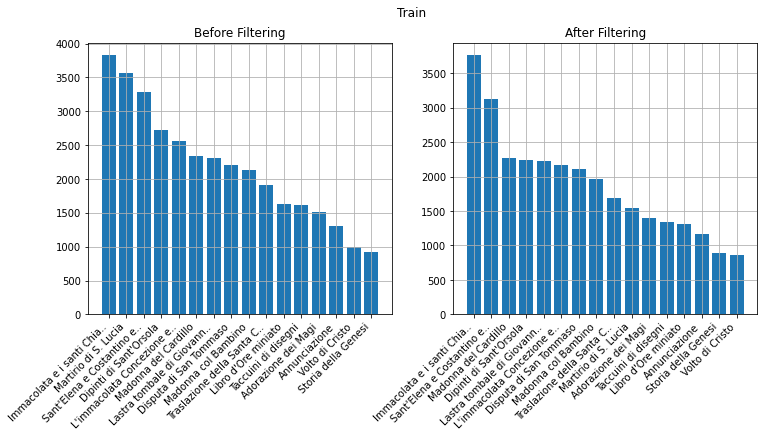

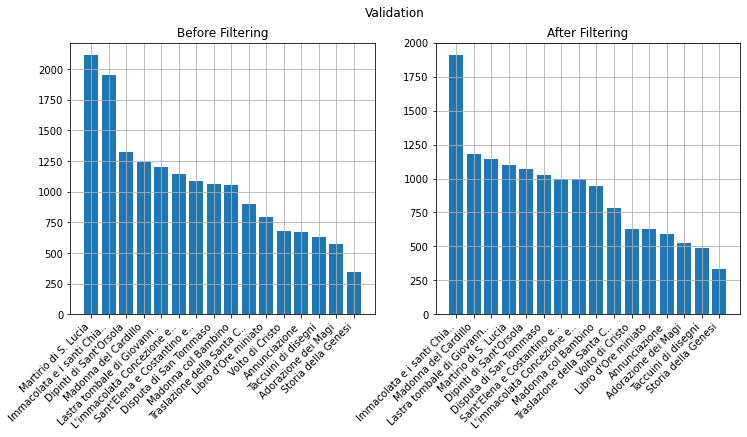

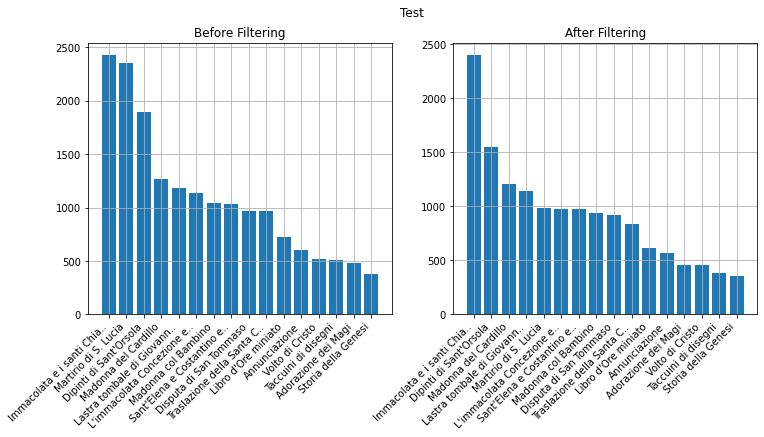

In [4]:
pixel_threshold = 30
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train(pixel_threshold)
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val(pixel_threshold)
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(pixel_threshold)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')
plt.show()

#### 1.2.3 Transform pipeline

Mean and standard deviation for normalization:

In [7]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


In [6]:
mean=(0.28162546, 0.29239721, 0.31711673)
std=(0.17125229, 0.17715992, 0.18002949)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),             # CenterCrop instead of RandomCrop to make the test deterministic
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

#### 1.2.4 Training (filtered dataset)

In [ ]:
lr=2e-4
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="filtered_train", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/loss:.1f}",
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=50,
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[val_checkpoint_callback,
                                latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "filtered_train", "resnet18_lr_0.0001", "checkpoints" , "latest-epoch=29-step=28000.ckpt"))

In [6]:
# Evaluate the model on the held-out test set 
lr=2e-4
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="filtered_train", 
    version=global_resnet_model_name + "_lr_" + str(lr) + "_test")
trainer = pl.Trainer(accelerator=system_accelerator, devices=1, logger=logger)
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "filtered_train", "resnet18_lr_0.0002", "checkpoints" , "11-11268-0.1.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\Official_Training\filtered_train\resnet18_lr_0.0002\checkpoints\11-11268-0.1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\Official_Training\filtered_train\resnet18_lr_0.0002\checkpoints\11-11268-0.1.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.9788158535957336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.9788158535957336}]

#### 1.2.5 Result

TODO: mettere considerazioni, ad esempio quale dei due percorsi si è optato, se considerare il dataset filtrato o quello originale per lo studio

![ResNet Filtered Case](./docs/resnet_filtered_case.png)

Il valore ottimale di learning rate con i modelli valutati è 1e-4. ResNet18 (viola) si comporta leggermente meglio durante il training rispetto a ResNet50 (blu) sul task dato. I valori delle metriche prese in esame per il caso migliore validation/loss minima sono riportati nella seguente tabella:

|   Models | Accuracy | Precision |   Recall | F1-Score |
|:--------:|:--------:|:---------:|:--------:|:--------:|
| ResNet50 |   25.0%  |   25.0%   |   25.0%  |   25.0%  |
| ResNet18 |   25.0%  |   25.0%   |   25.0%  |   25.0%  |



### Filtering Overall Result

Per ora abbiamo constatato che il filtro migliora sia loss che accuracy del validation.

## 2. Domain adaptation study cases

### 2.1 Baseline approaches without adaption
The first case of study is to train the classifier on the synthetic dataset and then test it on the real dataset, then evaluate the performance.

 ### Study Cases

#### 2.1.1 The model is trained on synthetic images and tested on synthetic images (no domain shift)

The training is the same as above. [Case 2 filtered](#filter_case_2) is taken as it returns the best results.

In [18]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

print("Dataset set transform")
val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])
dm.set_test_trasform(val_and_test_transform)


Dataset setup
Classification dataset found.
Dataset applying filter
Dataset set transform


In [19]:
trainer = pl.Trainer(accelerator=system_accelerator)
model = CustomResNetModule(model=global_resnet_model, num_classes=16, lr=1e-4)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-4_m_0", "checkpoints" , "epoch=17-step=16902-val_loss=0.1.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-4_m_0\checkpoints\epoch=17-step=16902-val_loss=0.1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-4_m_0\checkpoints\epoch=17-step=16902-val_loss=0.1.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9791553616523743
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9791553616523743}]

 #### 2.1.1.1 Result

Perfomance analysis are the same as above in [Case 2 filtered](#filter_case_2).

#### 2.1.2 The model is trained on synthetic images and tested on real images (no adaptation)

Dataset setup
Classification dataset found.
Dataset applying filter
Dataset set transform


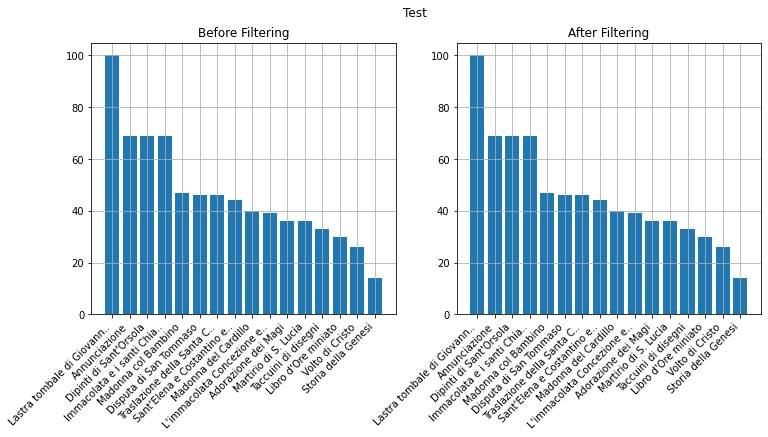

In [16]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(pixel_threshold=30)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')

print("Dataset set transform")
val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

dm.set_test_trasform(val_and_test_transform)
plt.show()

In [17]:
trainer = pl.Trainer(accelerator=system_accelerator)
model = CustomResNetModule(model=global_resnet_model, num_classes=16, lr=1e-4)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-4_m_0", "checkpoints" , "epoch=17-step=16902-val_loss=0.1.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-4_m_0\checkpoints\epoch=17-step=16902-val_loss=0.1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\filtered_train\ResNet_0_lr_1e-4_m_0\checkpoints\epoch=17-step=16902-val_loss=0.1.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc           0.029569892212748528
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.029569892212748528}]

 #### 2.1.2.1 Result

TODO: add performance analysis

#### 2.1.3 The model is trained on real images and tested on real images (Oracle)

In [1]:
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

Classification dataset found.


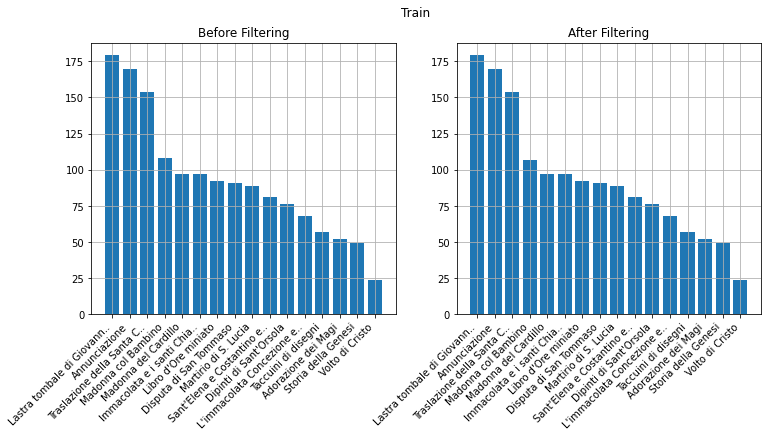

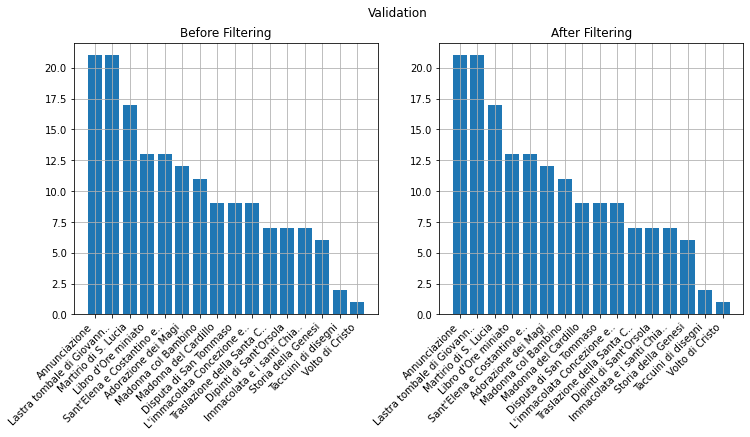

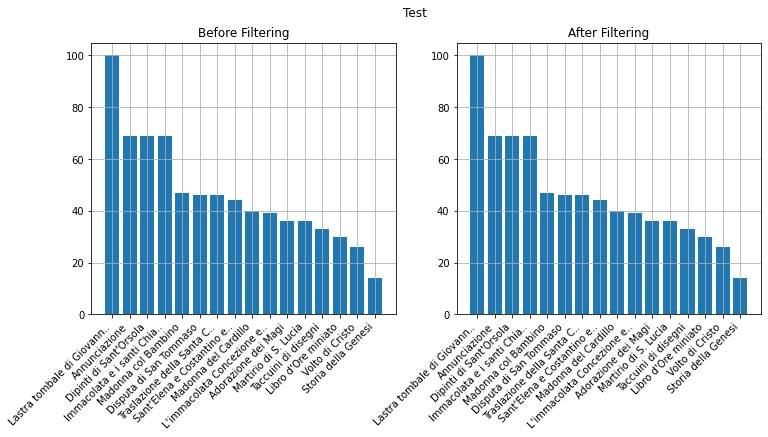

In [4]:
pixel_threshold = 30
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train(pixel_threshold)
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val(pixel_threshold)
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(pixel_threshold)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')
plt.show()

In [5]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45401238 0.39960463 0.31759819]
Std: [0.26222476 0.25603036 0.25329951]


In [6]:
mean=(0.45401238, 0.39960463, 0.31759819)
std=(0.26222476, 0.25603036, 0.25329951)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

In [ ]:
lr=1e-4
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="baseline_appr_3_real", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/loss:.1f}",
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=500,     
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[val_checkpoint_callback,
                                latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# Resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "baseline_appr_3_real", "resnet18_lr_0.0001", "checkpoints" , "latest-epoch=42-step=2000.ckpt"))

In [7]:
#IMPORTANT: used just to notify when the training is over
from scripts.utils.telegram_notifier import TelegramNotifier

TelegramNotifier().sendMessage(logger) # logger from training cell

In [6]:
trainer = pl.Trainer(accelerator=system_accelerator)
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "baseline_appr_3_real", "resnet18_lr_0.0001", "checkpoints" , "405-19082-1.2.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\Official_Training\baseline_appr_3_real\resnet18_lr_0.0001\checkpoints\405-19082-1.2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\Official_Training\baseline_appr_3_real\resnet18_lr_0.0001\checkpoints\405-19082-1.2.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.6088709831237793
      test/f1_score         0.6088709831237793
     test/precision         0.6088709831237793
       test/recall          0.6088709831237793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.6088709831237793,
  'test/precision': 0.6088709831237793,
  'test/recall': 0.6088709831237793,
  'test/f1_score': 0.6088709831237793}]

 #### 2.1.3.1 Result

TODO: add performance analysis

### 2.2 Domain adaptation through image-to-image translation (CycleGAN)

![CycleGAN](./docs/cycle_gan.png)

This section aims to apply image-to-image translation through CycleGAN PyTorch lightning implementation, building a pipeline to concatenate CycleGAN translated image between real and synthetic domains with ResNetModule. It is going to show 2 case of study:

1) Make the classifier use CycleGAN **real->synthetic** domain images during inference (**trained** using **synthetic domain** images).
2) Make the classifier use CycleGAN **synthetic->real** domain images during the training.

#### 2.2.1 CycleGAN Model

This section shows the CycleGAN PyTorch lightning implementation and how it is trained for pixel-level image-to-image translation.

In [3]:
import pytorch_lightning as pl
import itertools
import torchvision
from scripts.CycleGAN.generator import Generator
from scripts.CycleGAN.discriminator import Discriminator
from scripts.CycleGAN.utils import weights_init_normal, LambdaLR

class CycleGAN(pl.LightningModule):

    A2B = 0
    B2A = 1

    def __init__(self, 
                 input_nc = 3, 
                 output_nc = 3, 
                 lr=0.0002, 
                 betas=(0.5, 0.999), 
                 starting_epoch=0, 
                 n_epochs=200, 
                 decay_epoch=100,
                 print_images_each_N_batch = 500
                  ):
        super(CycleGAN, self).__init__()
        self.save_hyperparameters()
        
        # Generators A2B, B2A
        self.netG_A2B = Generator(input_nc, output_nc)
        self.netG_B2A = Generator(output_nc, input_nc)
        
        # A and B Discriminator
        self.netD_A = Discriminator(input_nc)
        self.netD_B = Discriminator(output_nc)
        
        # Normalization
        self.netG_A2B.apply(weights_init_normal)
        self.netG_B2A.apply(weights_init_normal)
        self.netD_A.apply(weights_init_normal)
        self.netD_B.apply(weights_init_normal)
        
        # Losses
        self.criterion_GAN = torch.nn.MSELoss()
        self.criterion_cycle = torch.nn.L1Loss()
        self.criterion_identity = torch.nn.L1Loss()
                    
    def forward(self, x, mode=A2B):
        if mode== CycleGAN.A2B:
            return self.netG_A2B(x)
        else:
            return self.netG_B2A(x)
    
    def configure_optimizers(self):
        # Generator Optimizer
        optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A2B.parameters(), self.netG_B2A.parameters()), lr=self.hparams.lr, betas=self.hparams.betas)
        
        # Discriminator Optimizers
        optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=self.hparams.lr, betas=self.hparams.betas)
        optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=self.hparams.lr, betas=self.hparams.betas)
        
        # Scheduler learning rate decay
        lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(self.hparams.n_epochs, self.hparams.starting_epoch, self.hparams.decay_epoch).step)
        lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(self.hparams.n_epochs, self.hparams.starting_epoch, self.hparams.decay_epoch).step)
        lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(self.hparams.n_epochs, self.hparams.starting_epoch, self.hparams.decay_epoch).step)
        
        return [optimizer_G, optimizer_D_A, optimizer_D_B], [lr_scheduler_G, lr_scheduler_D_A, lr_scheduler_D_B]
    
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_A, real_B = batch
        
        target_real = torch.ones((real_A.shape[0],1)).type_as(real_A)
        target_fake = torch.zeros((real_A.shape[0],1)).type_as(real_A)
        
        # Generator
        if optimizer_idx==0:
            # Identity loss
            # G_A2B(B) should equal B if real B is fed
            same_B = self.netG_A2B(real_B)
            loss_identity_B = self.criterion_identity(same_B, real_B)*5.0

            # G_B2A(A) should equal A if real A is fed
            same_A = self.netG_B2A(real_A)
            loss_identity_A = self.criterion_identity(same_A, real_A)*5.0

            # GAN loss
            fake_B = self.netG_A2B(real_A) 
            pred_fake = self.netD_B(fake_B) # discriminator B prediction
            loss_GAN_A2B = self.criterion_GAN(pred_fake, target_real) # loss GAN A2B

            fake_A = self.netG_B2A(real_B)
            pred_fake = self.netD_A(fake_A)  # discriminator A prediction
            loss_GAN_B2A = self.criterion_GAN(pred_fake, target_real) # loss GAN B2A

            # Cycle consistency loss
            recovered_A = self.netG_B2A(fake_B) #fake B -> B2A - should be same as real_A
            loss_cycle_ABA = self.criterion_cycle(recovered_A, real_A)*10.0 #cycle consistency loss

            recovered_B = self.netG_A2B(fake_A) #fake A -> A2B - should be same as real_B
            loss_cycle_BAB = self.criterion_cycle(recovered_B, real_B)*10.0 #cycle consistency loss

            # Overall loss
            loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            self.log('loss_G/loss_identity_A', loss_identity_A, on_epoch=True)
            self.log('loss_G/loss_identity_B', loss_identity_B, on_epoch=True)
            self.log('loss_G/loss_GAN_A2B', loss_GAN_A2B, on_epoch=True)
            self.log('loss_G/loss_GAN_B2A', loss_GAN_B2A, on_epoch=True)
            self.log('loss_G/loss_cycle_ABA', loss_cycle_ABA, on_epoch=True)
            self.log('loss_G/loss_cycle_BAB', loss_cycle_BAB, on_epoch=True)
            self.log('loss_G/overall', loss_G, on_epoch=True)
            
            # Log images to visually check the trainig
            if batch_idx % self.hparams.print_images_each_N_batch == 0:
                grid_A = torchvision.utils.make_grid(real_A[:50], nrow=10, normalize=True)
                grid_A2B = torchvision.utils.make_grid(fake_B[:50], nrow=10, normalize=True)
                grid_A2B2A = torchvision.utils.make_grid(recovered_A[:50], nrow=10, normalize=True)
                
                grid_B = torchvision.utils.make_grid(real_B[:50], nrow=10, normalize=True)
                grid_B2A = torchvision.utils.make_grid(fake_A[:50], nrow=10, normalize=True)
                grid_B2A2B = torchvision.utils.make_grid(recovered_B[:50], nrow=10, normalize=True)
                
                self.logger.experiment.add_image('A/A', grid_A, self.global_step)
                self.logger.experiment.add_image('A/A2B', grid_A2B, self.global_step)
                self.logger.experiment.add_image('A/A2B2A', grid_A2B2A, self.global_step)
                
                self.logger.experiment.add_image('B/B', grid_B, self.global_step)
                self.logger.experiment.add_image('B/B2A', grid_B2A, self.global_step)
                self.logger.experiment.add_image('B/B2A2B', grid_B2A2B, self.global_step)
                
            return loss_G
        
        # Discriminator A
        elif optimizer_idx==1:
            # Real loss
            pred_real = self.netD_A(real_A)
            loss_D_real = self.criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_A = self.netG_B2A(real_B)
            pred_fake = self.netD_A(fake_A.detach())
            loss_D_fake = self.criterion_GAN(pred_fake, target_fake)

            # loss globale
            loss_D_A = (loss_D_real + loss_D_fake)*0.5
            self.log('loss_D/loss_D_A',loss_D_A, on_epoch=True)
            return loss_D_A
        
        # Discriminator B
        elif optimizer_idx==2:
            pred_real = self.netD_B(real_B)
            loss_D_real = self.criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_B = self.netG_A2B(real_A) 
            pred_fake = self.netD_B(fake_B.detach())
            loss_D_fake = self.criterion_GAN(pred_fake, target_fake)

            # loss globale
            loss_D_B = (loss_D_real + loss_D_fake)*0.5
            self.log('loss_D/loss_D_B', loss_D_B, on_epoch=True)
            return loss_D_B

##### 2.2.1.1 Import Dataset

In [4]:
from scripts.dataset.GAN.data_module_GAN import CulturalSiteDataModuleGAN

batch_size = 2
dm = CulturalSiteDataModuleGAN(
    batch_size=batch_size, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGAN.ALL_STAGE)
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_test(pixel_threshold)

##### 2.2.1.2 Training

In [ ]:
lr=2e-4
model = CycleGAN(batch_size=batch_size, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="image_to_image_translation", 
    version="CycleGAN_lr_" + str(lr))

overall_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{loss_G/overall:.1f}",
    monitor="loss_G/overall",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1, 
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[ overall_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "no_filter_train", "ResNet_0_lr_1e-3_m_0", "checkpoints" , "epoch=9-step=9390.ckpt"))

#### 2.2.2 Case 1: Testing CycleGAN and ResNet (real->synthetic->inference)

Il modulo sotto implementa l'unione dei due modelli CycleGAN e ResNet, effettuando una traduzione dell'immagine reale -> synthetic e poi facendo inferenza con ResNet.

In [8]:
from scripts.CycleGAN.model import CycleGAN

class CycleGANResNetPretrainedModule(pl.LightningModule):
    
    def __init__(self, cycle_GAN_ckpt_path, res_net_ckpt_path):
        super(CycleGANResNetPretrainedModule, self).__init__()
        self.CycleGAN_model = CycleGAN.load_from_checkpoint(cycle_GAN_ckpt_path)
        self.CycleGAN_model.eval()
        self.ResNet_model = CustomResNetModule.load_from_checkpoint(res_net_ckpt_path)

        self.test_acc = torchmetrics.Accuracy()

    def forward(self, x): # x = real_B
        fake_A = self.CycleGAN_model(x, CycleGAN.B2A)
        self.print_images(x, fake_A)
        return self.ResNet_model(fake_A)

    def print_images(self, x, fake_A):
        grid_A = torchvision.utils.make_grid(x[:50], nrow=10, normalize=True)
        grid_A2B = torchvision.utils.make_grid(fake_A[:50], nrow=10, normalize=True)

        self.logger.experiment.add_image('A/A', grid_A, self.batch_idx)
        self.logger.experiment.add_image('A/A2B', grid_A2B, self.batch_idx)
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        self.batch_idx = batch_idx
        preds = self.forward(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test/accuracy', self.test_acc)       

 ##### 2.2.2.1 Dataset Setup

In [9]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=2, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
    
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
dm.filter_test(pixel_threshold=30)

print("Dataset set transform")
val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

dm.set_test_trasform(val_and_test_transform)

Dataset setup
Classification dataset found.
Dataset applying filter
Dataset set transform


 ##### 2.2.2.2 Testing

In [ ]:
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "image_to_image_translation"), 
    name="case_1_real_syn_inference", 
    version=global_resnet_model_name + "_lr_" + str(lr))

trainer = pl.Trainer(accelerator=system_accelerator, logger=logger)
model = CycleGANResNetPretrainedModule(
    cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_0_lr_0.0002", "checkpoints" , "epoch=0-step=45051-val_loss=0.0.ckpt"),
    res_net_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-4_m_0", "checkpoints" , "epoch=17-step=16902-val_loss=0.1.ckpt"))
    
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader())

##### 2.2.2.3 Result

TODO: add result

#### 2.2.3 Case 2: Training ResNet with CycleGAN translated images (synthetic->real->training)

In this section, we combine CycleGAN translated image dataset (synthetic->real) with ResNet, which is being trained using the real domain.

##### 2.2.3.1 Model

In [4]:
from scripts.CycleGAN.model import CycleGAN

class CycleGANResNetModule(pl.LightningModule):
    
    def __init__(self, cycle_GAN_ckpt_path, resnet_model, num_classes = 16, lr=1e-4):
        super(CycleGANResNetModule, self).__init__()
        self.num_classes = num_classes
        self.lr = lr
        
        self.CycleGAN_model = CycleGAN.load_from_checkpoint(cycle_GAN_ckpt_path)
        self.CycleGAN_model.eval()

        self.ResNet_model = CustomResNetModule(resnet_model=resnet_model, num_classes=num_classes, lr=lr)
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    def forward_cycleGAN(self, x): # x = real_A
        fake_B = self.CycleGAN_model(x, CycleGAN.A2B)
        # self.print_images(x, fake_B)
        return self.ResNet_model(fake_B)

    def forward(self, x): # x = real_A
        return self.ResNet_model(x)
            
    def print_images(self, x, fake_A):
        grid_A = torchvision.utils.make_grid(x[:50], nrow=10, normalize=True)
        grid_A2B = torchvision.utils.make_grid(fake_A[:50], nrow=10, normalize=True)

        self.logger.experiment.add_image('A/A', grid_A, self.batch_idx)
        self.logger.experiment.add_image('A/A2B', grid_A2B, self.batch_idx)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):   
        self.batch_idx = batch_idx
        x, y = batch        
        preds = self.forward_cycleGAN(x)        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('training/loss', loss.item(), on_epoch=True)
        self.log('training/accuracy', self.train_acc, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):        
        self.batch_idx = batch_idx
        x,y = batch        
        preds = self.forward(x)        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('validation/loss', loss.item(), on_epoch=True)
        self.log('validation/accuracy', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test/accuracy', self.test_acc, on_epoch=True)

##### 2.2.3.2 Synthetic dataset setup

In [5]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.ALL_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Dataset setup
Dataset applying filter


In [6]:
# Coming from baseline case 3 oracle
mean=(0.45401238, 0.39960463, 0.31759819)
std=(0.26222476, 0.25603036, 0.25329951)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

##### 2.2.3.3 Training

In [8]:
lr=4e-4
model = CycleGANResNetModule(
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
        num_classes=16,
        resnet_model= global_resnet_model,
        lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "image_to_image_translation"), 
    name="case_2_syn_real_training", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/loss:.1f}",
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False    
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1,    
                     accelerator=system_accelerator, 
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | CycleGAN_model | CycleGAN           | 28.3 M
1 | ResNet_model   | CustomResNetModule | 24.6 M
2 | loss_fn        | CrossEntropyLoss   | 0     
3 | train_acc      | Accuracy           | 0     
4 | val_acc        | Accuracy           | 0     
5 | test_acc       | Accuracy           | 0     
------------------------------------------------------
52.9 M    Trainable params
0         Non-trainable params
52.9 M    Total params
211.405   Total estimated model params size (MB)


Classification dataset found.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


##### 2.2.3.3 Testing

Real dataset setup

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [5]:
# Coming from baseline case 3 oracle
mean=(0.45401238, 0.39960463, 0.31759819)
std=(0.26222476, 0.25603036, 0.25329951)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [10]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = CycleGANResNetModule(
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=6-step=274500.ckpt"),
        num_classes=16,
        ResNet_model= global_resnet_model)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\image_to_image_translation\CycleGANResNetModule_0_lr_0.0001\checkpoints\latest-epoch=7-step=29000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\image_to_image_translation\CycleGANResNetModule_0_lr_0.0001\checkpoints\latest-epoch=7-step=29000.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.1827957034111023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.1827957034111023}]

##### 2.2.3.3 Result

TODO: add result

### 2.3 Feature-level Domain Adaptation

#### 2.3.1 Gradient Reversal layer

![Gradient Reversal Layer](./docs/gradient_reversal_layer.png)

Il principio è semplice:
- Feature Extractor (in verde): si occupa di estrarre le feature dai due domini
- Label predictor (in blu): si occupa di classificare rispetto alle label dei singoli domini
- Domain classifier (in rosa): si occupa di classificare e riconoscere a quale dominio appartiene l'immagine

La loss è cosi composta: 

$$ L = L_y - \lambda L_d $$

$ L_y $ è la loss del label predictor, $ L_d $ è la loss del domain classifier. Intuitivamente si vuole minimizzare la prima, ma massimizzare la seconda, in modo che il dominio a livello di feature non venga più distinto.

$ \lambda $ viene calcolato dirante il training secondo la seguente formula:

$$ \lambda_p = \frac{2}{1 + e^{-\gamma  p}} - 1 $$

$ \gamma = 10 $ e $ p \in [0, 1] $ (calcolato come `epoca_corrente/numero_di_epoche`).

Definizione del task di gradient reversal layer comprendente il modulo di GRL e discriminatore del dominio

##### 3.1.1 Training

In [4]:
NUM_EPOCHS=30

Model

In [3]:
from scripts.GRL.domain_discriminator import DomainDiscriminatorGRL
import numpy as np
import torch.nn.functional as F

class DomainAdaptationGRLTask(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super(DomainAdaptationGRLTask, self).__init__() 
        self.lr = lr
        self.model = model
        self.discriminator = DomainDiscriminatorGRL(in_features=model.in_features)

        self.val_acc =  torchmetrics.Accuracy()
        self.test_acc =  torchmetrics.Accuracy()

    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(list(self.model.parameters()) + list(self.discriminator.parameters()), lr=self.lr)

    def training_step(self, train_batch, batch_idx):
        source, target, labels = train_batch

        source_features = self.model.feature_extractor(source).view(source.shape[0], -1)
        target_features = self.model.feature_extractor(target).view(target.shape[0], -1)
        label_preds = self.model.classifier(source_features)

        # getting lambda val using original paper, from 0 to 1 following this formula
        lamb=2/(1+np.exp(-10*self.current_epoch/NUM_EPOCHS)) - 1

        domain_preds_source = self.discriminator(source_features, lamb)
        domain_preds_target = self.discriminator(target_features, lamb)
        domain_preds = torch.cat([domain_preds_source, domain_preds_target],0)

        source_acc = (torch.sigmoid(domain_preds_source)<0.5).float().mean()
        target_acc = (torch.sigmoid(domain_preds_target)>=0.5).float().mean()
        acc = (source_acc+target_acc)/2

        source_targets = torch.zeros(source.shape[0],1)
        target_targets = torch.ones(target.shape[0],1)
        domain_targets = torch.cat([source_targets, target_targets],0).type_as(source)

        label_loss = F.cross_entropy(label_preds, labels)
        domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_targets)
        loss = domain_loss + label_loss

        self.log('train/domain_loss', domain_loss)
        self.log('train/label_loss', label_loss)
        self.log('train/loss', loss)
        self.log('train/disc_source_acc',source_acc)
        self.log('train/disc_target_acc',target_acc)
        self.log('train/disc_acc',acc)
        return loss

    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        label_loss = F.cross_entropy(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)

        self.log('validation/label_loss', label_loss)
        self.log('validation/accuracy', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test/accuracy', self.test_acc, on_epoch=True)

Dataset Setup

In [6]:
from scripts.dataset.GRL.data_module_GRL import CulturalSiteDataModuleGRL

print("Dataset setup")
dm = CulturalSiteDataModuleGRL(
    batch_size=8, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGRL.FIT_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Dataset setup
Dataset applying filter


Normalization

Using zero-mean-nomalization, the cells below calculate mean and std for individual or merged datasets to implement a case of study where:
1. normalization using individual mean and std
2. normalization using global mean and std

In [6]:
syn_dataset = np.array(dm.cultural_site_train.get_syn_image_dataset())[:,1] #TODO: rename
real_img_dataset = np.array(dm.cultural_site_train.get_real_image_dataset())[:,1]
merged_dataset = np.concatenate((syn_dataset, real_img_dataset))

Getting mean and std for synthetic dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=syn_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


Getting mean and std for real dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=real_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45215473 0.39806145 0.31654662]
Std: [0.26077601 0.25441129 0.25139287]


Getting mean and std for merged dataset

In [7]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=merged_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28954191 0.29725961 0.31696455]
Std: [0.18010984 0.18290568 0.18407021]


Global transform pipeline

In [7]:
# Coming from cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

Training

In [ ]:
from scripts.models.custom_resnet_model import CustomResNetModule

lr=1e-4
model = DomainAdaptationGRLTask(
    model=CustomResNetModule(
        resnet_model=global_resnet_model,
        num_classes=16
    ),
    lr=lr
)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "feature_level_adapt"), 
    name="gradient_reversal_layer", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/accuracy:.1f}",
    monitor="validation/accuracy",
    mode="max",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1     
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

##### 3.1.2 Testing

Testing on syntetic dataset

In [4]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset setup
Dataset applying filter


In [5]:
# Coming from Case 1.2 filtered
mean=(0.28162546, 0.29239721, 0.31711673)
std=(0.17125229, 0.17715992, 0.18002949)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [7]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = DomainAdaptationGRLTask(
    model=CustomResNetModule(
        resnet_model=global_resnet_model,
        num_classes=16
    ))
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "feature_level", "DomainAdaptationGRLTask_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\feature_level\DomainAdaptationGRLTask_0_lr_0.0001\checkpoints\latest-epoch=0-step=500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\feature_level\DomainAdaptationGRLTask_0_lr_0.0001\checkpoints\latest-epoch=0-step=500.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.13851167261600494
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.13851167261600494}]

Testing on real dataset

In [8]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset setup
Dataset applying filter


In [9]:
# Coming from baseline case 3 oracle
mean=(0.45401238, 0.39960463, 0.31759819)
std=(0.26222476, 0.25603036, 0.25329951)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [10]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = DomainAdaptationGRLTask(
    model=CustomResNetModule(
        resnet_model=global_resnet_model,
        num_classes=16
    ))
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "feature_level", "DomainAdaptationGRLTask_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\feature_level\DomainAdaptationGRLTask_0_lr_0.0001\checkpoints\latest-epoch=0-step=500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\feature_level\DomainAdaptationGRLTask_0_lr_0.0001\checkpoints\latest-epoch=0-step=500.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.11290322244167328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.11290322244167328}]

##### 3.1.3 Result

TODO: add result

#### 2.3.2 Adversarial Domain Adaptation (ADDA)

Defining ADDA task

In [3]:
from scripts.models.custom_resnet_model import CustomResNetModule
from scripts.ADDA.discriminator import Discriminator

class ADDATask(pl.LightningModule):

    def __init__(self, source_model, resnet_model, num_classes, lr=1e-3): # ResNetModule loaded from ckpy
        super(ADDATask, self).__init__() 
        self.lr = lr
        self.source_model = source_model
        self.target_model = CustomResNetModule(resnet_model=resnet_model, num_classes=num_classes)
        self.target_model.load_state_dict(self.source_model.state_dict())
        self.target_model = self.target_model.feature_extractor

        self.discriminator = Discriminator(self.source_model.classifier[0].in_features)
        self.criterion = nn.BCEWithLogitsLoss() # TODO: controllare se è uguale a quella di GRL, cambiare per non sembrare copia e incolla

        self.accuracy = torchmetrics.Accuracy()

    def forward(self,x):
        features = self.target_model(x).view(x.shape[0],-1)
        return self.source_model.classifier(features)

    def configure_optimizers(self):
        return torch.optim.Adam(self.discriminator.parameters(), lr=self.lr), torch.optim.Adam(self.target_model.parameters(), lr=self.lr)

    def training_step(self, train_batch, batch_idx, optimizer_idx):
        source, target, _ = train_batch

        if optimizer_idx==0: #train discriminator
            source_features = self.source_model.feature_extractor(source).view(source.shape[0], -1)
            target_features = self.target_model(target).view(target.shape[0], -1)

            discriminator_x = torch.cat([source_features, target_features])
            discriminator_y = torch.cat([torch.ones(source.shape[0]).type_as(source), torch.zeros(target.shape[0]).type_as(source)])

            preds = self.discriminator(discriminator_x).squeeze()
            loss = self.criterion(preds, discriminator_y)

            self.log('training/d_loss', loss)

            return loss

        else: #train generator
            target_features = self.target_model(target).view(target.shape[0], -1)

            # flipped labels
            discriminator_y = torch.ones(target.shape[0]).type_as(source)

            preds = self.discriminator(target_features).squeeze()
            loss = self.criterion(preds, discriminator_y)

            self.log('training/g_loss', loss)

            return loss

    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('validation/accuracy', self.accuracy, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('test/accuracy', self.accuracy, on_epoch=True)


##### 2.3.2.1 Training

Dataset Setup

In [4]:
from scripts.dataset.GRL.data_module_GRL import CulturalSiteDataModuleGRL

print("Dataset setup")
dm = CulturalSiteDataModuleGRL(
    batch_size=32, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGRL.ALL_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Dataset setup
Dataset applying filter


Normalization

 Using zero-mean-nomalization, the cells below calculate mean and std for individual or merged datasets to implement a case of study where:
1. normalization using individual mean and std
2. normalization using global mean and std

In [ ]:
syn_dataset = np.array(dm.cultural_site_train.get_syn_image_dataset())[:,1] #TODO: rename
real_img_dataset = np.array(dm.cultural_site_train.get_real_image_dataset())[:,1]
merged_dataset = np.concatenate((syn_dataset, real_img_dataset))

Getting mean and std for synthetic dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=syn_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


Getting mean and std for real dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=real_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45215473 0.39806145 0.31654662]
Std: [0.26077601 0.25441129 0.25139287]


Getting mean and std for merged dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=merged_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28954191 0.29725961 0.31696455]
Std: [0.18010984 0.18290568 0.18407021]


Global transform pipeline

In [5]:
# Coming from cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

Training

In [6]:
lr=1e-3
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = ADDATask(source_model=source_model, resnet_model=global_resnet_model, num_classes=16, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "feature_level_adapt"), 
    name="ADDA", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/accuracy:.1f}",
    monitor="validation/accuracy",
    mode="max",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1      
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1,
                     accelerator=system_accelerator, 
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\danil\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'source_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['source_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


##### 3.1.2 Testing

Testing on syntetic dataset

In [3]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset setup
Dataset applying filter


In [4]:
# Coming from cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [7]:
# Evaluate the model on the held-out test set 
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = ADDATask(source_model=source_model, resnet_model=global_resnet_model, num_classes=16)

trainer = pl.Trainer(accelerator=system_accelerator)
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "feature_level", "ADDATask_0_lr_0.001", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'source_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['source_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\feature_level\ADDATask_0_lr_0.001\checkpoints\latest-epoch=0-step=500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\feature_level\ADDATask_0_lr_0.001\checkpoints\latest-epoch=0-step=500.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.10503802448511124
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.10503802448511124}]

Testing on real dataset

In [8]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset setup
Dataset applying filter


In [9]:
# Coming from cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [10]:
# Evaluate the model on the held-out test set 
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = ADDATask(source_model=source_model, resnet_model=global_resnet_model, num_classes=16)

trainer = pl.Trainer(accelerator=system_accelerator)
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "feature_level", "ADDATask_0_lr_0.001", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\feature_level\ADDATask_0_lr_0.001\checkpoints\latest-epoch=0-step=500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\feature_level\ADDATask_0_lr_0.001\checkpoints\latest-epoch=0-step=500.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.0927419364452362
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.0927419364452362}]

##### 2.3.2.3 Result

TODO: add result

### 2.4 Combining Image-to-image translation and Feature-level domain adaptation

In questo caso si è deciso di combinare i due approcci presentati nei punti 2.2 e 2.3. Il goal è quello di avvicinare i due domini prima dell'estrazione delle features.

#### 2.4.1 Training ResNet (CycleGAN -> Gradient Reversal Layer -> ResNet)

Le immagini vengono tradotte con CycleGAN mentre vengono proposte al feature extractor, in questo modo vengono avvicinati ulteriormente i due domini sorgente e target.

##### 2.4.1.1 Model

In [3]:
NUM_EPOCHS = 50 # utile per calcolare $ \lambda $

In [8]:
from scripts.GRL.domain_discriminator import DomainDiscriminatorGRL
import numpy as np
import torch.nn.functional as F
from scripts.CycleGAN.model import CycleGAN

class CycleGANGRLTask(pl.LightningModule):
    def __init__(self, model, cycle_GAN_ckpt_path, lr=1e-3):
        super(CycleGANGRLTask, self).__init__() 
        self.lr = lr
        self.cycleGAN_model = CycleGAN.load_from_checkpoint(cycle_GAN_ckpt_path)
        self.cycleGAN_model.eval()
        
        self.model = model
        self.discriminator = DomainDiscriminatorGRL(in_features=model.in_features)

        self.val_acc =  torchmetrics.Accuracy()
        self.test_acc =  torchmetrics.Accuracy()

    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(list(self.model.parameters()) + list(self.discriminator.parameters()), lr=self.lr)

    def training_step(self, train_batch, batch_idx):
        source, target, labels = train_batch

        fake_B_source = self.cycleGAN_model(source, CycleGAN.A2B)
        source_features = self.model.feature_extractor(fake_B_source).view(fake_B_source.shape[0], -1)
        target_features = self.model.feature_extractor(target).view(target.shape[0], -1)
        label_preds = self.model.classifier(source_features)

        # getting lambda val using original paper, from 0 to 1 following this formula
        l=2/(1+np.exp(-10*self.current_epoch/NUM_EPOCHS)) - 1

        domain_preds_source = self.discriminator(source_features, l)
        domain_preds_target = self.discriminator(target_features, l)
        domain_preds = torch.cat([domain_preds_source, domain_preds_target],0)

        source_acc = (torch.sigmoid(domain_preds_source)<0.5).float().mean()
        target_acc = (torch.sigmoid(domain_preds_target)>=0.5).float().mean()
        acc = (source_acc+target_acc)/2

        source_targets = torch.zeros(source.shape[0],1)
        target_targets = torch.ones(target.shape[0],1)
        domain_targets = torch.cat([source_targets, target_targets],0).type_as(source)

        label_loss = F.cross_entropy(label_preds, labels)
        domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_targets)
        loss = domain_loss + label_loss

        self.log('train/domain_loss', domain_loss)
        self.log('train/label_loss', label_loss)
        self.log('train/loss', loss)
        self.log('train/disc_source_acc',source_acc)
        self.log('train/disc_target_acc',target_acc)
        self.log('train/disc_acc',acc)
        return loss

    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        label_loss = F.cross_entropy(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)

        self.log('validation/label_loss', label_loss)
        self.log('validation/accuracy', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test/accuracy', self.test_acc, on_epoch=True)

##### 2.4.1.2 Training

In [5]:
from scripts.dataset.GRL.data_module_GRL import CulturalSiteDataModuleGRL

print("Dataset setup")
dm = CulturalSiteDataModuleGRL(
    batch_size=8, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGRL.FIT_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Dataset setup
Dataset applying filter


Normalization

Using zero-mean-nomalization, the cells below calculate mean and std for individual or merged datasets to implement a case of study where:
1. normalization using individual mean and std
2. normalization using global mean and std

In [ ]:
syn_dataset = np.array(dm.cultural_site_train.get_syn_image_dataset())[:,1] #TODO: rename
real_img_dataset = np.array(dm.cultural_site_train.get_real_image_dataset())[:,1]
merged_dataset = np.concatenate((syn_dataset, real_img_dataset))

Getting mean and std for synthetic dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=syn_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


Getting mean and std for real dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=real_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45215473 0.39806145 0.31654662]
Std: [0.26077601 0.25441129 0.25139287]


Getting mean and std for merged dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=merged_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28954191 0.29725961 0.31696455]
Std: [0.18010984 0.18290568 0.18407021]


Global transform pipeline

In [6]:
# Coming from baseline cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

#TODO: add optional to Other case (Single syn, single real, both ecc....)

In [10]:
lr=1e-4
model = CycleGANGRLTask(
        model=CustomResNetModule(
            resnet_model=global_resnet_model,
            num_classes=16
        ),
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
        lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "combined_iti_fl"), 
    name="CycleGAN_GRLTask", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/accuracy:.1f}",
    monitor="validation/accuracy",
    mode="max",
    save_top_k=1,  
    auto_insert_metric_name=False    
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                     accelerator=system_accelerator, 
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

NameError: name 'CycleGANGRLTask' is not defined

##### 2.4.1.3 Testing on synthetic dataset

In [11]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset setup
Dataset applying filter


In [12]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [15]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = CycleGANGRLTask(
        model=CustomResNetModule(
            resnet_model=global_resnet_model,
            num_classes=16
        ),
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"))
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "cycleGAN_feature_level", "CycleGANGRLTask_0_0.0001", "checkpoints" , "latest-epoch=0-step=1500.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\cycleGAN_feature_level\CycleGANGRLTask_0_0.0001\checkpoints\latest-epoch=0-step=1500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\cycleGAN_feature_level\CycleGANGRLTask_0_0.0001\checkpoints\latest-epoch=0-step=1500.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.1976507306098938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.1976507306098938}]

##### 2.4.1.4 Testing on real dataset

In [16]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset setup
Dataset applying filter


In [17]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [18]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = CycleGANGRLTask(
        model=CustomResNetModule(
            resnet_model=global_resnet_model,
            num_classes=16
        ),
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"))
       
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "cycleGAN_feature_level", "CycleGANGRLTask_0_0.0001", "checkpoints" , "latest-epoch=0-step=1500.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\cycleGAN_feature_level\CycleGANGRLTask_0_0.0001\checkpoints\latest-epoch=0-step=1500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\cycleGAN_feature_level\CycleGANGRLTask_0_0.0001\checkpoints\latest-epoch=0-step=1500.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.19086021184921265
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/accuracy': 0.19086021184921265}]

##### 2.4.1.5 Result

TODO: add result

#### 2.4.2 Training ResNet (CycleGAN -> ADDA -> ResNet)

Approccio simile a quanto visto sopra ma implementa ADDA.

##### 2.4.2.1 Model

In [8]:
from scripts.models.custom_resnet_model import CustomResNetModule
from scripts.ADDA.discriminator import Discriminator
from scripts.CycleGAN.model import CycleGAN

class CycleGANADDATask(pl.LightningModule):

    def __init__(self, source_model, resnet_model, cycle_GAN_ckpt_path, num_classes, lr=1e-3): # ResNetModule loaded from ckpy
        super(CycleGANADDATask, self).__init__() 
        self.lr = lr

        self.cycleGAN_model = CycleGAN.load_from_checkpoint(cycle_GAN_ckpt_path)
        self.cycleGAN_model.eval()

        self.source_model = source_model
        self.target_model = CustomResNetModule(resnet_model=resnet_model, num_classes=num_classes)
        self.target_model.load_state_dict(self.source_model.state_dict())
        self.target_model = self.target_model.feature_extractor

        self.discriminator = Discriminator(self.source_model.classifier[0].in_features)
        self.criterion = nn.BCEWithLogitsLoss()

        self.accuracy = torchmetrics.Accuracy()

    def forward(self,x):
        features = self.target_model(x).view(x.shape[0],-1)
        return self.source_model.classifier(features)

    def configure_optimizers(self):
        return torch.optim.Adam(self.discriminator.parameters(), lr=self.lr), torch.optim.Adam(self.target_model.parameters(), lr=self.lr)

    def training_step(self, train_batch, batch_idx, optimizer_idx):
        source, target, _ = train_batch

        if optimizer_idx==0: #train discriminator
            fake_B_source = self.cycleGAN_model(source, CycleGAN.A2B)
            source_features = self.source_model.feature_extractor(fake_B_source).view(fake_B_source.shape[0], -1)
            target_features = self.target_model(target).view(target.shape[0], -1)

            discriminator_x = torch.cat([source_features, target_features])
            discriminator_y = torch.cat([torch.ones(source.shape[0]).type_as(source), torch.zeros(target.shape[0]).type_as(source)])

            preds = self.discriminator(discriminator_x).squeeze()
            loss = self.criterion(preds, discriminator_y)

            self.log('train/d_loss', loss)

            return loss

        else: #train generator
            target_features = self.target_model(target).view(target.shape[0], -1)

            # flipped labels
            discriminator_y = torch.ones(target.shape[0]).type_as(source)

            preds = self.discriminator(target_features).squeeze()
            loss = self.criterion(preds, discriminator_y)

            self.log('train/g_loss', loss)

            return loss

    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('validation/accuracy', self.accuracy, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('test/accuracy', self.accuracy, on_epoch=True)


##### 2.4.2.2 Training

In [9]:
from scripts.dataset.GRL.data_module_GRL import CulturalSiteDataModuleGRL

print("Dataset setup")
dm = CulturalSiteDataModuleGRL(
    batch_size=8, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGRL.FIT_STAGE) #TODO: check why ALL_STAGE or TEST_STAGE are broken

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Dataset setup
Dataset applying filter


Normalization

Using zero-mean-nomalization, the cells below calculate mean and std for individual or merged datasets to implement a case of study where:
1. normalization using individual mean and std
2. normalization using global mean and std

In [ ]:
syn_dataset = np.array(dm.cultural_site_train.get_syn_image_dataset())[:,1] #TODO: rename
real_img_dataset = np.array(dm.cultural_site_train.get_real_image_dataset())[:,1]
merged_dataset = np.concatenate((syn_dataset, real_img_dataset))

Getting mean and std for synthetic dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=syn_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


Getting mean and std for real dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=real_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45215473 0.39806145 0.31654662]
Std: [0.26077601 0.25441129 0.25139287]


Getting mean and std for merged dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=merged_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28954191 0.29725961 0.31696455]
Std: [0.18010984 0.18290568 0.18407021]


Global transform pipeline

In [10]:
# Coming from baseline cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

#TODO: add optional to Other case (Single syn, single real, both ecc....)

In [11]:
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = CycleGANADDATask(
    source_model=source_model, 
    resnet_model=global_resnet_model, 
    cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
    num_classes=16)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "combined_iti_fl"), 
    name="CycleGAN_ADDATask", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/accuracy:.1f}",
    monitor="validation/accuracy",
    mode="max",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1      
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1,
                     accelerator=system_accelerator, 
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'source_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['source_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | cycleGAN_model | CycleGAN           | 28.3 M
1 | source_model   | CustomResNetModule | 24.6 M
2 | target_model   | Sequential         | 23.5 M
3 | discriminator  | Discriminator      | 103 K 
4 | criterion      | BCEWithLogitsLoss  | 0     
5 | accuracy       | Accuracy           | 0     
------------------------------------------------------
76.5 M    Trainable params
0         Non-tr

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

c:\Users\danil\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


##### 2.4.2.3 Testing on synthetic domain

In [14]:
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset applying filter


In [15]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [17]:
# Evaluate the model on the held-out test set 
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = CycleGANADDATask(
    source_model=source_model, 
    resnet_model=global_resnet_model, 
    cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
    num_classes=16)

trainer = pl.Trainer(accelerator=system_accelerator)
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "cycleGAN_feature_level", "CycleGANADDATask_0", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at e:\github\deep-learning-project\tb_logs\cycleGAN_feature_level\CycleGANADDATask_0\checkpoints\latest-epoch=0-step=500.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at e:\github\deep-learning-project\tb_logs\cycleGAN_feature_level\CycleGANADDATask_0\checkpoints\latest-epoch=0-step=500.ckpt


Testing: 0it [00:00, ?it/s]

##### 2.4.2.4 Testing on real domain

In [ ]:
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [ ]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = CycleGANADDATask(
    source_model=source_model, 
    resnet_model=global_resnet_model, 
    cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
    num_classes=16)
    
trainer = pl.Trainer(accelerator=system_accelerator)
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "cycleGAN_feature_level", "CycleGANADDATask_0", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

##### 2.4.2.5 Result

TODO: add result

## 3. Overall Result

TODO: ADD considerazioni finali sui risultati